In [ ]:
pip install feedparser pandas python-dateutil


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=3d5f49606df77ac5bb305d2738762720aa30e20f64baec6c7da88cec9d36d4f1
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [ ]:
from datetime import datetime, timezone
import pandas as pd

# Configuriamo i casi di studio
#
# Le finestre temporali sono fissate, ma per ogni caso usiamo PIÙ query
# per aumentare il numero di articoli rilevanti.

CASES = {
    "SVB": {
        "from": datetime(2023, 3, 10, tzinfo=timezone.utc),   # incluso
        "to":   datetime(2023, 3, 18, tzinfo=timezone.utc),   # escluso 18
        "queries": [
            # versione “base”
            '"Silicon Valley Bank" banking system',
            '"Silicon Valley Bank" collapse',
            '"Silicon Valley Bank" bailout',
            '"Silicon Valley Bank" crisis',
            '"Silicon Valley Bank" failure contagion',
            # con operatori temporali nel testo (Google può o meno considerarli)
            '"Silicon Valley Bank" banking system after:2023-03-06 before:2023-03-16',
            '"Silicon Valley Bank" collapse after:2023-03-06 before:2023-03-16'
        ]
    },

    "Netflix": {
        "from": datetime(2022, 4, 19, tzinfo=timezone.utc),   # incluso
        "to":   datetime(2022, 5, 4, tzinfo=timezone.utc),    # escluso 4
        "queries": [
            'Netflix streaming market',
            'Netflix streaming market subscribers',
            '"Netflix" subscribers loss',
            '"Netflix" subscriber loss April 2022',
            '"Netflix" earnings April 2022',
            # versione con operatori nel testo
            'Netflix streaming market after:2022-04-19 before:2022-05-04',
            '"Netflix" subscribers after:2022-04-19 before:2022-05-04'
        ]
    }
}

CASES


{'SVB': {'from': datetime.datetime(2023, 3, 10, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2023, 3, 18, 0, 0, tzinfo=datetime.timezone.utc),
  'queries': ['"Silicon Valley Bank" banking system',
   '"Silicon Valley Bank" collapse',
   '"Silicon Valley Bank" bailout',
   '"Silicon Valley Bank" crisis',
   '"Silicon Valley Bank" failure contagion',
   '"Silicon Valley Bank" banking system after:2023-03-06 before:2023-03-16',
   '"Silicon Valley Bank" collapse after:2023-03-06 before:2023-03-16']},
 'Netflix': {'from': datetime.datetime(2022, 4, 19, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc),
  'queries': ['Netflix streaming market',
   'Netflix streaming market subscribers',
   '"Netflix" subscribers loss',
   '"Netflix" subscriber loss April 2022',
   '"Netflix" earnings April 2022',
   'Netflix streaming market after:2022-04-19 before:2022-05-04',
   '"Netflix" subscribers after:2022-04-19 before:20

In [ ]:
import urllib.parse
import time
from dateutil import parser as date_parser
import feedparser


def build_google_news_rss_url(query: str) -> str:
    """
    Costruisce l'URL RSS di Google News per una query testuale.
    Non usiamo parametri di lingua/paese ma prendiamo la versione di default.
    """
    encoded_query = urllib.parse.quote(query)
    url = f"https://news.google.com/rss/search?q={encoded_query}"
    return url


def parse_feed(url: str):
    """
    Scarica e fa il parsing di un feed RSS con feedparser.
    """
    feed = feedparser.parse(url)
    if feed.bozo:
        print(f"[WARN] Problema nel parsing di {url}: {feed.bozo_exception}")
    return feed


def entry_pubdate_to_datetime(entry):
    """
    Converte la data di pubblicazione di una entry in datetime UTC.
    """
    for key in ["published", "pubDate", "updated"]:
        value = entry.get(key)
        if value:
            try:
                dt = date_parser.parse(value)
                if dt.tzinfo is None:
                    dt = dt.replace(tzinfo=timezone.utc)
                else:
                    dt = dt.astimezone(timezone.utc)
                return dt
            except Exception:
                continue
    return None


def collect_news_for_case(case_name: str, config: dict):
    """
    Raccoglie tutte le notizie Google News per un caso di studio (SVB / Netflix),
    usando TUTTE le query definite in CASES[case_name]["queries"].
    """
    results = []

    start = config["from"]
    end = config["to"]
    queries = config["queries"]

    print(f"\n=== Case: {case_name} ===")
    print(f"Window: {start.isoformat()} → {end.isoformat()}")
    print(f"Numero di query: {len(queries)}")

    for q_idx, query in enumerate(queries, start=1):
        print(f"\n  [Q{q_idx}/{len(queries)}] Query: {query}")
        url = build_google_news_rss_url(query)
        print(f"    [*] Fetching: {url}")

        feed = parse_feed(url)

        for entry in feed.entries:
            dt = entry_pubdate_to_datetime(entry)
            if dt is None:
                continue

            # filtro temporale rigoroso lato Python
            if not (start <= dt < end):
                continue

            title = entry.get("title", "").strip()
            link = entry.get("link", "").strip()

            # source
            source = ""
            if "source" in entry and hasattr(entry["source"], "title"):
                source = entry["source"].title
            elif "source" in entry:
                source = str(entry["source"])
            elif "author" in entry:
                source = entry["author"]

            results.append({
                "case": case_name,
                "title": title,
                "source": source,
                "published_utc": dt,
                "link": link,
                "query": query,   # per tracciare da quale query è arrivato
            })

        # piccola pausa per non stressare troppo Google
        time.sleep(1)

    print(f"\n  → Trovati {len(results)} articoli (prima di eventuale deduplica interna) per {case_name}")
    return results


In [ ]:
all_articles = []

for case_name, cfg in CASES.items():
    case_articles = collect_news_for_case(case_name, cfg)
    all_articles.extend(case_articles)

print(f"\nTotale articoli (prima della deduplica globale): {len(all_articles)}")

df = pd.DataFrame(all_articles)

if not df.empty:
    df_before = len(df)

    # Deduplica: prima per link (più robusto), poi per (case, title, source, published_utc)
    if "link" in df.columns:
        df = df.drop_duplicates(subset=["case", "link"])

    df = df.drop_duplicates(subset=["case", "title", "source", "published_utc"])

    df_after = len(df)
    print(f"Rimossi {df_before - df_after} duplicati, articoli finali: {df_after}")

    # Ordiniamo per caso e data
    df = df.sort_values(by=["case", "published_utc"]).reset_index(drop=True)
else:
    print("Nessun articolo raccolto: controlla la connessione o la configurazione delle query.")

df.head()



=== Case: SVB ===
Window: 2023-03-10T00:00:00+00:00 → 2023-03-18T00:00:00+00:00
Numero di query: 7

  [Q1/7] Query: "Silicon Valley Bank" banking system
    [*] Fetching: https://news.google.com/rss/search?q=%22Silicon%20Valley%20Bank%22%20banking%20system

  [Q2/7] Query: "Silicon Valley Bank" collapse
    [*] Fetching: https://news.google.com/rss/search?q=%22Silicon%20Valley%20Bank%22%20collapse

  [Q3/7] Query: "Silicon Valley Bank" bailout
    [*] Fetching: https://news.google.com/rss/search?q=%22Silicon%20Valley%20Bank%22%20bailout

  [Q4/7] Query: "Silicon Valley Bank" crisis
    [*] Fetching: https://news.google.com/rss/search?q=%22Silicon%20Valley%20Bank%22%20crisis

  [Q5/7] Query: "Silicon Valley Bank" failure contagion
    [*] Fetching: https://news.google.com/rss/search?q=%22Silicon%20Valley%20Bank%22%20failure%20contagion

  [Q6/7] Query: "Silicon Valley Bank" banking system after:2023-03-06 before:2023-03-16
    [*] Fetching: https://news.google.com/rss/search?q=%22Silic

,case,title,source,published_utc,link,query
0,Netflix,Netflix shares down more than 20% after losing...,TechCrunch,2022-04-19 07:00:00+00:00,https://news.google.com/rss/articles/CBMitwFBV...,"""Netflix"" subscribers loss"
1,Netflix,Netflix Reports Loss of Subscribers for the Fi...,globaldata.com,2022-04-19 07:00:00+00:00,https://news.google.com/rss/articles/CBMi1AFBV...,"""Netflix"" subscribers loss"
2,Netflix,Netflix to Start “Pulling Back” Content Spend ...,hollywoodreporter.com,2022-04-19 07:00:00+00:00,https://news.google.com/rss/articles/CBMikAFBV...,"""Netflix"" subscriber loss April 2022"
3,Netflix,Netflix just lost $50 billion in market cap - CNN,CNN,2022-04-19 07:00:00+00:00,https://news.google.com/rss/articles/CBMiY0FVX...,"""Netflix"" subscriber loss April 2022"
4,Netflix,"Netflix Loses 200,000 Subscribers in Q1, Predi...",Variety,2022-04-19 07:00:00+00:00,https://news.google.com/rss/articles/CBMiigFBV...,"""Netflix"" subscriber loss April 2022"


In [ ]:
output_path = "google_news_svb_netflix_multiquery.csv"

if not df.empty:
    df.to_csv(output_path, index=False)
    print(f"Salvato CSV in: {output_path}")
else:
    print("DataFrame vuoto: nessun CSV salvato.")


Salvato CSV in: google_news_svb_netflix_multiquery.csv


In [ ]:
# CONTROLLO ACCESSIBILITÀ LINK (QUALITY CHECK)
import requests
from tqdm import tqdm

TIMEOUT = 10
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; GoogleNewsDatasetCheck/1.0)"
}

def check_link_safe(url):
    """
    Controlla se un link è accessibile.
    Non solleva eccezioni.
    Ritorna:
        - link_ok (bool)
        - http_status (int | None)
    """
    try:
        r = requests.head(
            url,
            headers=HEADERS,
            timeout=TIMEOUT,
            allow_redirects=True
        )
        return True, r.status_code
    except Exception:
        try:
            r = requests.get(
                url,
                headers=HEADERS,
                timeout=TIMEOUT,
                allow_redirects=True
            )
            return True, r.status_code
        except Exception:
            return False, None


# Copia del DataFrame (df NON viene modificato)
df_link_check = df.copy()

results = []

print("Avvio controllo accessibilità dei link...")
for url in tqdm(df_link_check["link"], desc="Checking links"):
    ok, status = check_link_safe(url)
    results.append({
        "link_ok": ok,
        "http_status": status
    })

# Aggiungiamo SOLO a df_link_check
df_link_check = pd.concat


Avvio controllo accessibilità dei link...


Checking links: 100%|██████████| 412/412 [00:53<00:00,  7.69it/s]


In [ ]:
# Preparazione dataset per analisi

# Usa il dataset principale
df_analysis = df.copy()

# Convertiamo il timestamp in data (livello giornaliero)
df_analysis["date"] = df_analysis["published_utc"].dt.date

# Controllo veloce
print("Numero totale articoli:", len(df_analysis))
print(df_analysis[["case", "date"]].head())


Numero totale articoli: 412
      case        date
0  Netflix  2022-04-19
1  Netflix  2022-04-19
2  Netflix  2022-04-19
3  Netflix  2022-04-19
4  Netflix  2022-04-19


In [ ]:
#
# Sanity Check: Numero articoli per giorno
#

counts = (
    df_analysis
    .groupby(["case", "date"])
    .size()
    .reset_index(name="n_articles")
)

counts


,case,date,n_articles
0,Netflix,2022-04-19,33
1,Netflix,2022-04-20,46
2,Netflix,2022-04-21,18
3,Netflix,2022-04-22,10
4,Netflix,2022-04-23,4
5,Netflix,2022-04-24,1
6,Netflix,2022-04-25,7
7,Netflix,2022-04-26,7
8,Netflix,2022-04-27,4
9,Netflix,2022-04-28,3


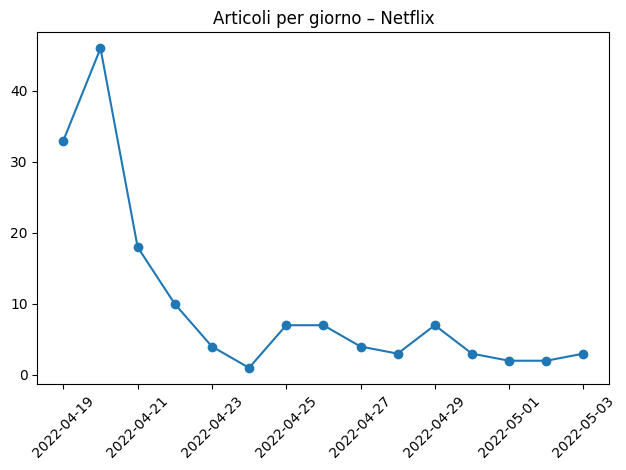

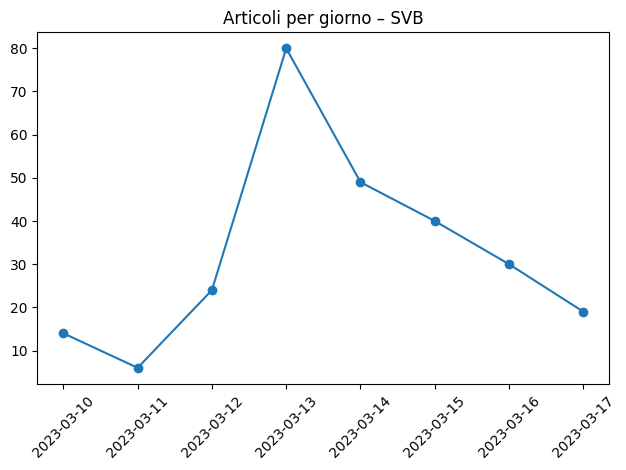

In [ ]:
import matplotlib.pyplot as plt

for case in counts["case"].unique():
    subset = counts[counts["case"] == case]
    plt.figure()
    plt.plot(subset["date"], subset["n_articles"], marker="o")
    plt.title(f"Articoli per giorno – {case}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
